In [58]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

import scipy.stats as stats
from scipy.stats import kurtosis, skew

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet, Lasso, Ridge, ElasticNetCV, LassoCV, RidgeCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

Loading Datasets

In [59]:
#Loading the datasets
path = "dataset/"
train = pd.read_csv(path+"train.csv")
test = pd.read_csv(path+"test.csv")

In [60]:
y_test_df = pd.read_csv(path+"sample_submission.csv")
y_test_df.drop(['Id'], axis=1, inplace=True)
print(y_test_df.shape)
#print(y_test.shape)

(1459, 1)


In [61]:
#Rows and cols in the dataset

#Train dataset has 1460 sales and 80 featuresv + 1 target variable(Sale Price)
#Test dataset has 1459 sales and 80 features

print ("Train: ",train.shape[0],"sales, and ",train.shape[1],"features")
print ("Test: ",test.shape[0],"sales, and ",test.shape[1],"features")

Train:  1460 sales, and  81 features
Test:  1459 sales, and  80 features


In [62]:
#identifying categorical and Numerical variables

#Brute force by using the datatype of the variable
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

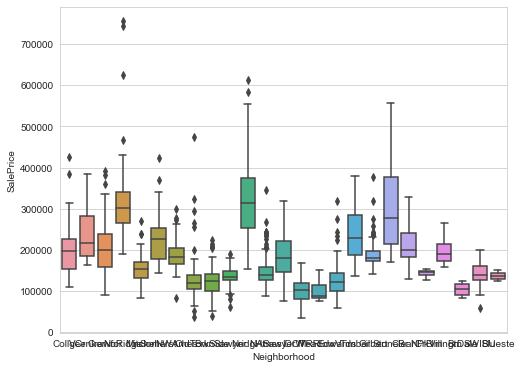

In [63]:
data = pd.concat([train['SalePrice'], train['Neighborhood']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='Neighborhood', y="SalePrice", data=data)

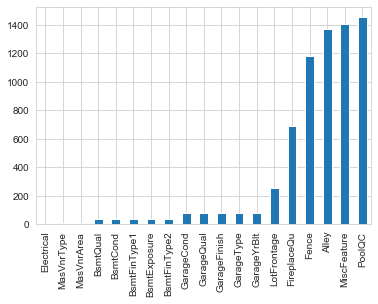

In [64]:
#Basic Bar plot indicating number of missing values in the columns 
sns.set_style("whitegrid")
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

<h3>Distribution of the target variable</h3>



 mu = 180921.20 and sigma = 79415.29


 mu = 12.02 and sigma = 0.40



Text(0.5, 0.98, 'After transformation')

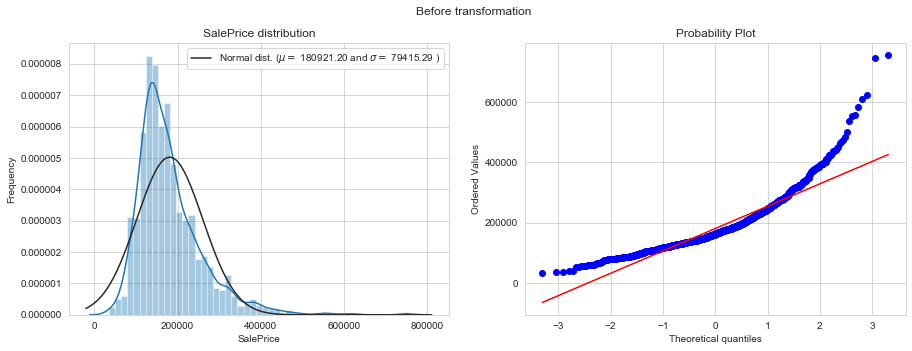

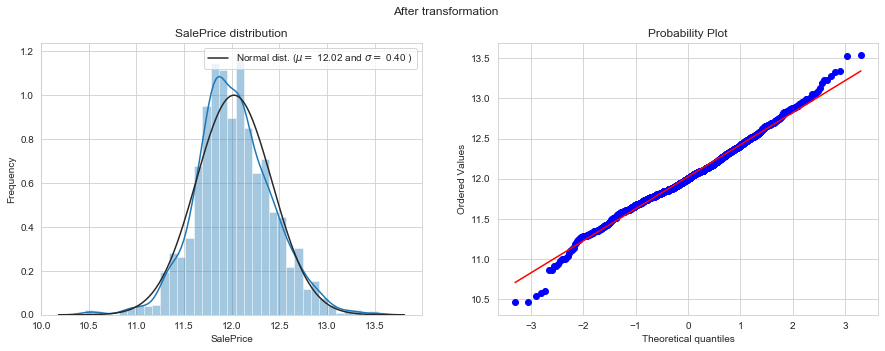

In [65]:
# Plot histogram and probability
from scipy.stats import norm, skew
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train['SalePrice'] , fit=norm);
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
plt.subplot(1,2,2)
res = stats.probplot(train['SalePrice'], plot=plt)
plt.suptitle('Before transformation')

# Apply transformation
train.SalePrice = np.log1p(train.SalePrice )

# New prediction
y_train = train.SalePrice.values
y_train_orig = train.SalePrice


# Plot histogram and probability after transformation
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train['SalePrice'] , fit=norm);
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
plt.subplot(1,2,2)
res = stats.probplot(train['SalePrice'], plot=plt)
plt.suptitle('After transformation')

SalePrice doesn't follow normal distribution.Hence Log transformation is applied 

In [66]:
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(train[quantitative])
normal = normal.apply(test_normality)
print(not normal.any())

False


None of the quantitative variables are normally distributed.


In [67]:
#removal of unwanted cols (for the purpose of cleaning data) such as 'id' and target i.e Sale Price
train.drop(['Id'], axis=1, inplace=True)#dropping id from train dataset
test.drop(['Id'], axis=1, inplace=True)#dropping id from train dataset

In [68]:
train = train[train.GrLivArea < 4500] #getting rid of outliers present in GrLivArea
train.reset_index(drop=True, inplace=True)
train["SalePrice"] = np.log1p(train["SalePrice"])#transforming saleprice to log(1+x)
y = train['SalePrice'].reset_index(drop=True)

In [69]:
train_features = train.drop(['SalePrice'], axis=1)#features that our models will be tried upon
test_features = test
features = pd.concat([train_features, test_features]).reset_index(drop=True)

Handling "NA" values

In [70]:
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)
features['Functional'] = features['Functional'].fillna('Typ') 
features['Electrical'] = features['Electrical'].fillna("SBrkr") 
features['KitchenQual'] = features['KitchenQual'].fillna("TA") 
features["PoolQC"] = features["PoolQC"].fillna("None")
features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0]) 
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

In [71]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    features[col] = features[col].fillna(0)

for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    features[col] = features[col].fillna('None')

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('None')

features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

In [72]:
features.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,None,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,None,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,None,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,None,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,None,NaN,NaN,0,12,2008,WD,Normal


In [73]:
features.tail()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
2912,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,None,NaN,NaN,0,6,2006,WD,Normal
2913,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,None,NaN,NaN,0,4,2006,WD,Abnorml
2914,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,None,NaN,NaN,0,9,2006,WD,Abnorml
2915,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,None,MnPrv,Shed,700,7,2006,WD,Normal
2916,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,None,NaN,NaN,0,11,2006,WD,Normal


In [74]:
objects = []
for i in features.columns:
    if features[i].dtype == object:
        objects.append(i)
features.update(features[objects].fillna('None'))

features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics.append(i)
features.update(features[numerics].fillna(0))

In [75]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics2.append(i)
skew_features = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

In [76]:
features = features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

features['YrBltAndRemod']=features['YearBuilt']+features['YearRemodAdd']
features['TotalSF']=features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']

features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                                 features['1stFlrSF'] + features['2ndFlrSF'])

features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                               features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))

features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                              features['WoodDeckSF'])

In [77]:
features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [78]:
features.shape

(2917, 86)

In [79]:
#Convert categorical variable into dummy/indicator variables.

final_features = pd.get_dummies(features).reset_index(drop=True)
final_features.shape

(2917, 333)

In [80]:
X = final_features.iloc[:len(y), :]
X.shape
X_sub = final_features.iloc[len(y):, :] #X_sub has test data
X.shape, y.shape, X_sub.shape

((1458, 333), (1458,), (1459, 333))

In [81]:
outliers = [30, 88, 462, 631, 1322]
X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])

overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.94:
        overfit.append(i)

overfit = list(overfit)
X = X.drop(overfit, axis=1)
X_sub = X_sub.drop(overfit, axis=1)

<h1>MODELS</h1>

<H6>LASSO</H6>

0.7247027851138789


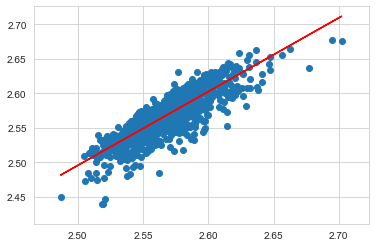

In [82]:
#LASSO
lasso = Lasso()
lasso.fit(X,y)
y_p = lasso.predict(X)
print(lasso.score(X,y))

denom = y_p.dot(y_p) - y_p.mean() * y_p.sum()
m = ( y_p.dot(y) - y.mean() * y_p.sum()) / denom
b = ( y.mean() * y_p.dot(y_p) - y_p.mean() * y_p.dot(y)) / denom
y_predi = m*y_p + b
plt.scatter(y_p,y)
plt.plot(y_p,y_predi,'r')

test score lasso: -3.1374193212644013
train score lasso: 0.7247027851138789


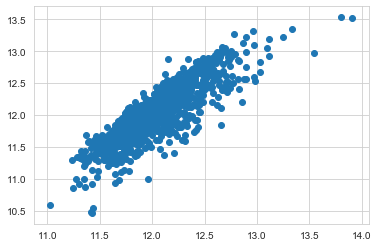

In [83]:
#the next three cells examine over fitting effects:(with increase in accuarcy of train data, with the help of tuning of hyper 
#parameters i.e alpha)

def score(y_pred, y_true):
    error = np.square(np.log10(y_pred+1) - np.log10(y_true+1)).mean() ** 0.5
    score = 1 - error
    return score

lar = Lasso()
lar.fit(X,y)
train_score=lar.score(X,y)
y_pred_train = lar.predict(X)
y_pred_lass =lar.predict(X_sub)


l=[]
for i in y_pred_lass:
    l.append(np.expm1(i))

y1 = y_test_df['SalePrice']

actual = list(y1)

actual = np.asarray(actual)

print("test score lasso:",score(np.asarray(l),actual))
print("train score lasso:",train_score)
plt.scatter(np.expm1(y_pred_train),np.expm1(y))

train score lasso_001: 0.8541675458593343
test score lasso_001: -3.137508764793817


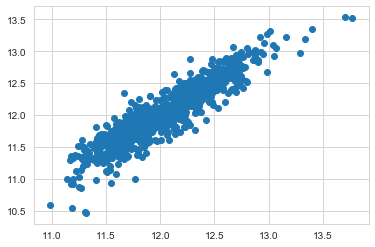

In [84]:
lasso001 = Lasso(alpha=0.01, max_iter=10e5)
lasso001.fit(X,y)
print("train score lasso_001:",lasso001.score(X,y))

y_pred_lass_001 = lasso001.predict(X_sub)
y_pred_train001 = lasso001.predict(X)
l_001 = []
for i in y_pred_lass_001:
    l_001.append(np.expm1(i))
    
print("test score lasso_001:",score(np.asarray(l_001),actual))

plt.scatter(np.expm1(y_pred_train001),np.expm1(y))

train score lasso_00001: 0.9333903117185385
test score lasso_001: -3.137475824617126


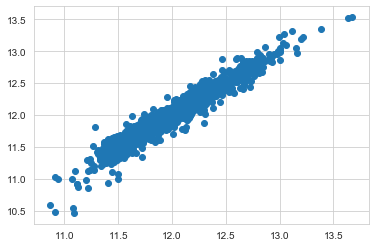

In [85]:
lasso00001 = Lasso(alpha=0.0001, max_iter=10e5)
lasso00001.fit(X,y)
print("train score lasso_00001:",lasso00001.score(X,y))

y_pred_lass_00001 = lasso00001.predict(X_sub)
y_pred_train00001 = lasso00001.predict(X)
l_00001 = []
for i in y_pred_lass_00001:
    l_00001.append(np.expm1(i))
    
print("test score lasso_001:",score(np.asarray(l_00001),actual))
plt.scatter(np.expm1(y_pred_train00001),np.expm1(y))

<H6>RIDGE</H6>

0.9538464034258368
-3.1374193212644013


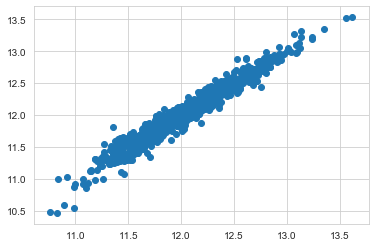

In [86]:
rig = Ridge()
rig.fit(X,y)
y_pred_rig =rig.predict(X_sub)
y_pred_train_rig =rig.predict(X)

r=[]
for i in y_pred_rig:
    r.append(np.expm1(i))
    
y1 = y_test_df['SalePrice']

actual = list(y1)
actual = np.asarray(actual)

print(rig.score(X,y))
print(score(np.asarray(l),actual))

plt.scatter(np.expm1(y_pred_train_rig),np.expm1(y))

<H6>RANDOM FOREST</H6>

In [87]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

In [ ]:
#time taking step
rf.fit(X,y)

In [ ]:
y_pred_rf =rf.predict(X_sub)
#print(y_pred_rf)

In [ ]:
y1 = y_test_df['SalePrice']
def score(y_pred, y_true):
    error = np.square(np.log10(y_pred +1) - np.log10(y_true +1)).mean() ** 0.5
    score = 1 - error
    return score
p=[]
for i in y_pred_rf:
    p.append(np.expm1(i))

y_pred_train_rf = rf.predict(X)
actual = list(y1)
actual = np.asarray(actual)

print("test score:",score(np.asarray(p),actual))
print("train score:",rf.score(X,y))
plt.scatter(np.expm1(y_pred_train_rf),np.expm1(y))

<H6>GRADIENT BOOSTING REGRESSOR</H6>

In [ ]:
gbdt_model = GradientBoostingRegressor(learning_rate=0.2, min_samples_leaf=5, min_samples_split=10, max_depth=4, n_estimators=3000)
#time taking step
gbdt_model.fit(X,y)
y_pred_xg =gbdt_model.predict(X_sub)
y_pred_train_xg =gbdt_model.predict(X)
y1 = y_test_df['SalePrice']
def score(y_pred, y_true):
    error = np.square(np.log10(y_pred +1) - np.log10(y_true +1)).mean() ** 0.5
    score = 1 - error
    return score
l=[]
for i in y_pred_xg:
    l.append(np.expm1(i))

actual = list(y1)
actual = np.asarray(actual)

print("train score:",gbdt_model.score(X,y))
print("test score:",score(np.asarray(l),actual))

plt.scatter(np.expm1(y_pred_train_xg),np.expm1(y))